# Detection and classification demo workflow

In [29]:
import os
import json
import glob
from random import shuffle

import cv2
import numpy as np
import torch
from torchmetrics import detection, F1Score
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultPredictor
from detectron2.engine.defaults import DefaultPredictor
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import rasterio
import pandas as pd

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Mon_Apr__3_17:16:06_PDT_2023
Cuda compilation tools, release 12.1, V12.1.105
Build cuda_12.1.r12.1/compiler.32688072_0
torch:  2.1 ; cuda:  cu121
detectron2: 0.6


### Set up

In [3]:
data_dir = "/home/ubuntu/data/"
model_dir = "/home/ubuntu/model/"

In [4]:
# Register the partitioned COCO datasets for building detection
register_coco_instances("hp_train", {}, f"{data_dir}coco/instances_default_train.json", f"{data_dir}mapillary_images")
register_coco_instances("hp_val", {}, f"{data_dir}coco/instances_default_val.json", f"{data_dir}mapillary_images")
register_coco_instances("hp_test", {}, f"{data_dir}coco/instances_default_test.json", f"{data_dir}mapillary_images")

In [5]:
# Read the partitioned COCO datasets into dictionaries for later use
train_json = open(f"{data_dir}coco/instances_default_train.json")
train_json = json.load(train_json)
val_json = open(f"{data_dir}coco/instances_default_val.json")
val_json = json.load(val_json)
test_json = open(f"{data_dir}coco/instances_default_test.json")
test_json = json.load(test_json)

#### Check some images and labels

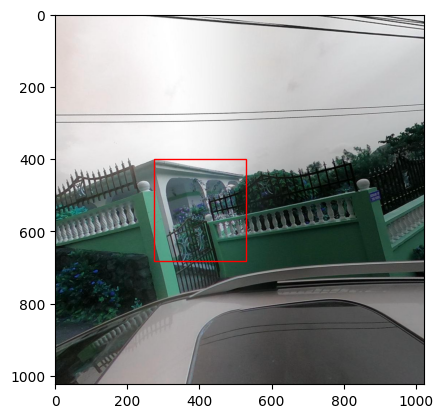

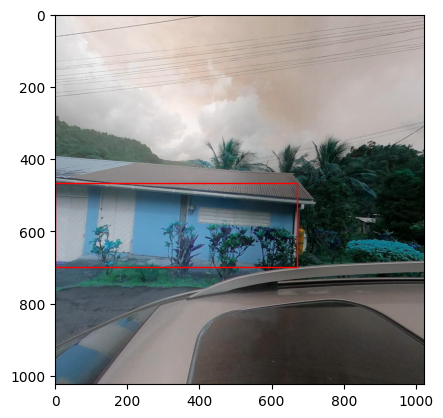

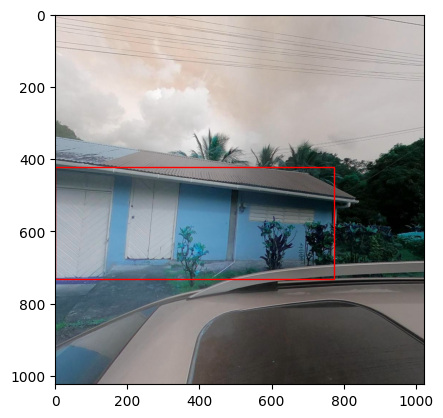

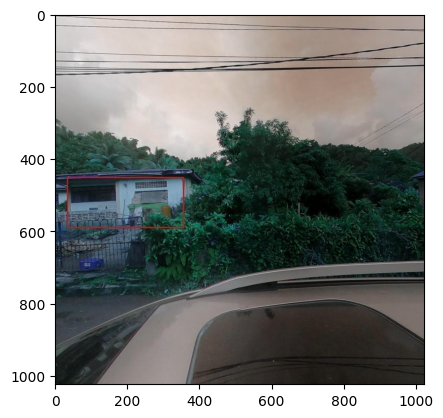

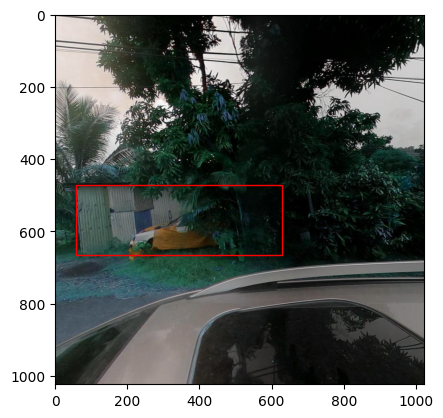

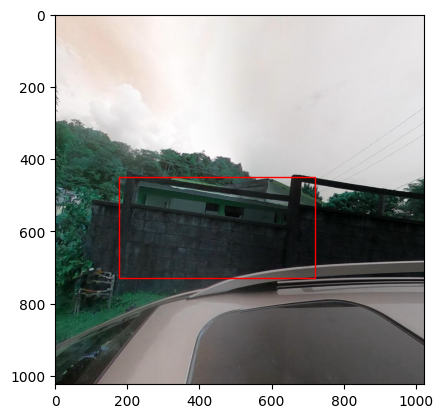

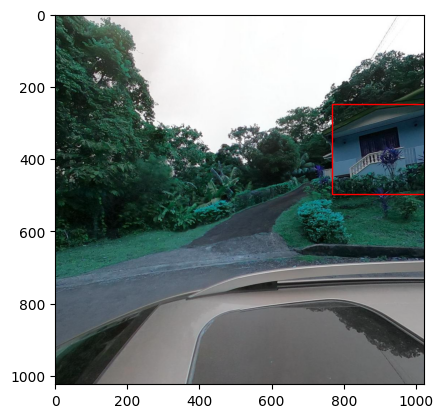

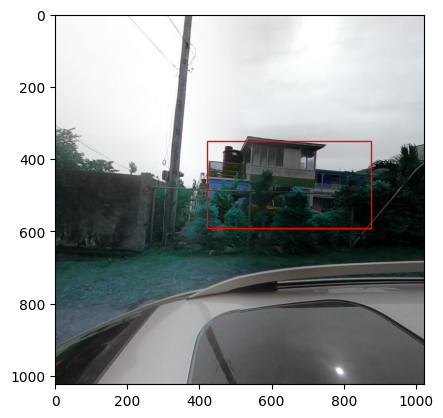

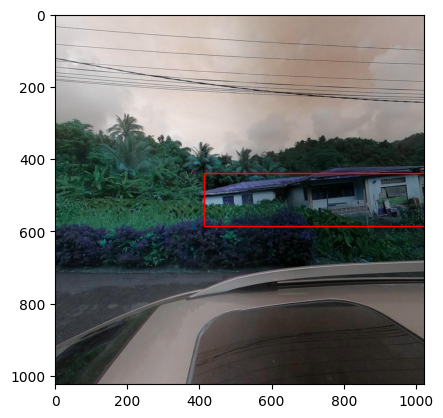

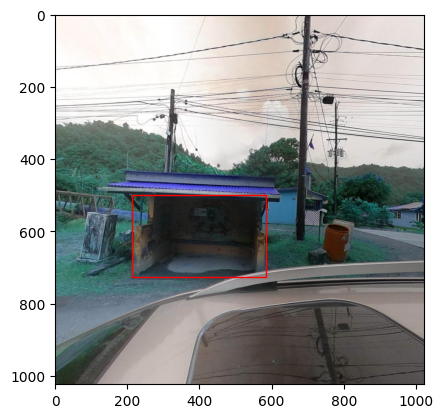

In [101]:
i=0
for gt in train_json['annotations'][0:10]:
    for im in train_json['images']:
        if gt['image_id'] == im['id']:
            img = cv2.imread(f"{data_dir}mapillary_images/"+im['file_name'])
            fig, ax = plt.subplots()
            ax.imshow(img)
            rect_name = f'rect_{i}'
            class Rectv:
                rect_name = f'rect_{i}'
            r = Rectv()
            setattr(r, rect_name, rect_name)
            r.rect_name = patches.Rectangle(
                (gt['bbox'][0], gt['bbox'][1]),
                gt['bbox'][2],
                gt['bbox'][3],
                linewidth=1,
                edgecolor='r',
                facecolor='none'
            )
            ax.add_patch(r.rect_name)
            i=i+1
        else:
            continue

    plt.show() 

### Load the model

In [92]:
os.chdir(model_dir)

In [7]:
detector_cpkt_path = f"{model_dir}output/50kiter/model_final.pth"

In [ ]:
# Set up configuration details for the Detectron2 training experiment
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml")) #faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = os.path.join(detector_cpkt_path)
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
cfg.DATASETS.TEST = ("hp_test",)
predictor = DefaultPredictor(cfg)

#### Check the logs of the trained model 

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
#%reload_ext tensorboard
%tensorboard --logdir output/50kiter/

### Run inference

In [10]:
# In case we'd like to store our test images with inferences plotted
inference_image_output = "./output/test_inference_images/"
os.makedirs(inference_image_output, exist_ok=True)

#### Generate predictions and plot them on some subset of the test dataset

In [ ]:
outputs_test = []
for gt in test_json['annotations'][0:10]:
  for i in test_json['images']:
    if gt['image_id'] == i['id']:
      im = cv2.imread(f"{data_dir}mapillary_images/"+i['file_name'])
      outputs = predictor(im)
      #print(outputs["instances"].pred_boxes)
      outputs_test.append(outputs)
      # Use `Visualizer` to draw the predictions on the image.
      v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
      out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
      bb = gt['bbox']
      bbxyxy = (bb[0], bb[1], bb[0]+bb[2], bb[1]+bb[3])
      out = v.draw_box(box_coord = bbxyxy, edge_color='dodgerblue')


      pred_image = out.get_image()[:, :, ::-1]
    
      window_name = "prediction"
    
      # Display the image using imshow
      #cv2.imshow(window_name, pred_image)
      #cv2.waitKey(0)
      #cv2.destroyAllWindows()
      #cv2.imshow(out.get_image()[:, :, ::-1])
      cv2.imwrite(f"{inference_image_output}{i['file_name'].replace('/', '_')}", out.get_image()[:, :, ::-1])
      #print("written to ", f"{inference_image_output}{i['file_name'].replace('/', '_')}")

In [ ]:
ls ./output/test_inference_images/

#### Visualize one of the resulting images

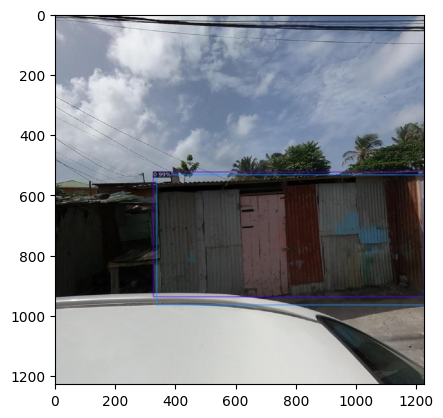

In [15]:
import matplotlib.image as mpimg

# Specify the path to your image
image_path = './output/test_inference_images/r7tGTdge9ZQXVPAcNbiEnu_left_1966801483681588_left.jpg'

# Load the image using matplotlib.image.imread
img = mpimg.imread(image_path)

# Plot the image using matplotlib.pyplot.imshow
plt.imshow(img)


### Run evaluation of the trained model on the test dataset
We'll calculate mean average precision (mAP) as our score.

In [ ]:
# Use the test dataset
dataset_name = "hp_test"

# Load metadata and dataset
metadata = MetadataCatalog.get(dataset_name)
dataset_dicts = DatasetCatalog.get(dataset_name)

# Lists to store predicted and ground truth bounding boxes
outputs_test_preds = []
outputs_test_gt = []

# Iterate over annotations in the test dataset
for t in test_json['annotations']:
    # Get the image path from the test dataset
    image_path = [i['file_name'] for i in test_json['images'] if i['id'] == t['image_id']]
    
    # Read the image using OpenCV
    im = cv2.imread(f"{data_dir}mapillary_images/{image_path[0]}")
    
    # Make predictions using the trained model
    outputs = predictor(im)
    
    try:
        # Get ground truth annotations for the current image
        annotations = dataset_dicts[t['image_id']]["annotations"]
        gt_boxes = [ann["bbox"] for ann in annotations]
        
        # Check if there are both predicted and ground truth bounding boxes
        if gt_boxes and outputs["instances"].pred_boxes:
            # Convert ground truth bounding boxes to the required format (xywh -> xyxy)
            gt_boxes = [[bb[0], bb[1], bb[0] + bb[2], bb[1] + bb[3]] for bb in gt_boxes]
            
            # Convert predicted bounding boxes and labels to tensors
            pred_boxes = torch.stack([torch.tensor(b) for b in outputs["instances"].pred_boxes])
            gt_boxes = torch.stack([torch.tensor(list(b)) for b in gt_boxes])
            labels = [1] * len(outputs["instances"].pred_boxes)
            labels_preds = torch.stack([torch.tensor(l) for l in labels])
            labels = [1] * len(gt_boxes)
            labels_gts = torch.stack([torch.tensor(l) for l in labels])
            
            # Create dictionaries for ground truth and predicted bounding boxes
            gt = {'image_id': t['image_id'], 'labels': labels_gts, 'boxes': gt_boxes}
            prd = {'image_id': t['image_id'], 'labels': labels_preds, 'boxes': pred_boxes, 'scores': outputs["instances"].scores}
            
            # Append the dictionaries to the respective lists
            outputs_test_preds.append(prd)
            outputs_test_gt.append(gt)
    
    except Exception as e:
        # Handle exceptions, e.g., when ground truth annotations are not available
        print(f"Exception: {e}")
        pass

In [17]:
# whole test set
m = detection.mean_ap.MeanAveragePrecision(box_format='xyxy', iou_type='bbox', iou_thresholds=[0.0], rec_thresholds=None, max_detection_thresholds=None, class_metrics=False)

m.update(preds=outputs_test_preds, target=outputs_test_gt)

from pprint import pprint

pprint(m.compute()['map'])

tensor(0.8115)


### Run detection, clipping and classification

In [13]:
# go to the location of the repo
os.chdir(f"{model_dir}housing-passports-v2/")

In [ ]:
from src.datamodule import HouseDataModule
from src.model import HPClassifier
from detect_clip_classify import evaluate_classification_model, clip_image_around_bbox_buffer, load_classification_model
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, ToPILImage

In [ ]:
# load the trained model
classification_ckpt_path = "/home/ubuntu/.aim/63869a95ae444b3d87f78331/checkpoints/epoch:48-step:12838-loss:2.419-f1:4.245.ckpt"
classification_model = load_classification_model(classification_ckpt_path)
classification_model.to(classification_model.device)  

In [86]:
# iterate through the first 100 images in the test dataset
cumulative_predictions = []
for gt in test_json['annotations'][0:100]:
    for i in test_json['images']:
        if gt['image_id'] == i['id']:
            im = cv2.imread(f"{data_dir}mapillary_images/"+i['file_name'])
            outputs = predictor(im)
            bb_scores = outputs["instances"].scores
            box_num = 0
            if outputs["instances"].pred_boxes:
                for bb, sc in zip(outputs["instances"].pred_boxes, outputs["instances"].scores):
                    bbox_data = bb.tolist() 
                    clipped_img = clip_image_around_bbox_buffer(im, bbox_data)
                    img = torch.tensor(clipped_img.transpose(2,0,1)).to(torch.float32)
                    img = ToPILImage()(img)
                    transform = Compose([
                        Resize((512,512), antialias=True),
                        ToTensor(),
                        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ])
                    img = transform(img)
                    img = img.unsqueeze(0)
                    image_clipped_output_dirs = i['file_name'].split('/')
                    os.makedirs(os.path.join("./output/test_inference_images", image_clipped_output_dirs[0]), exist_ok=True)
                    os.makedirs(os.path.join("./output/test_inference_images", image_clipped_output_dirs[0], \
                                             image_clipped_output_dirs[1]), exist_ok=True)
                        
                    if len(outputs["instances"].pred_boxes) > 1:
                        box_num=box_num+1
                        categories = evaluate_classification_model(classification_model, img, classification_model.device)
                        image_boxes_categories = {"image_name": i['file_name'], "boxes": bbox_data, "box_scores": sc, \
                                                  "complete": categories["complete"], "condition": categories["condition"], \
                                                  "material": categories["material"], "security": categories["security"], \
                                                  "use": categories["use"], "image_name_clip": f"{i['file_name'][:-4]}_{box_num}.jpg", \
                                                  "ground_truth": gt['attributes']}
                            
                        cumulative_predictions.append(image_boxes_categories)
                        cv2.imwrite(os.path.join("./output/test_inference_images/", f"{i['file_name'][:-4]}_{box_num}.jpg"), clipped_img)
                    else:
                        categories = evaluate_classification_model(classification_model, img, classification_model.device)
                        image_boxes_categories = {"image_name": i['file_name'], "boxes": bbox_data, "box_scores": sc, \
                                                  "complete": categories["complete"], "condition": categories["condition"], \
                                                  "material": categories["material"], "security": categories["security"], \
                                                  "use": categories["use"], "image_name_clip": f"{i['file_name']}", \
                                                  "ground_truth": gt['attributes']}
                        cumulative_predictions.append(image_boxes_categories)
                        cumulative_gt_attributes.append(gt['attributes'])
                        cv2.imwrite(os.path.join("./output/test_inference_images/", f"{i['file_name']}"), clipped_img)
                        

In [87]:
# make a dataframe of the predictions
df_preds = pd.DataFrame(cumulative_predictions)

#### Visualize some results

File  rb3QV25WsP0NdylOHZSzxE/left/995792421751752_left.jpg  with ground truth attributes  {'building_completeness': 'complete', 'building_condition': 'poor', 'building_material': 'mix-other-unclear', 'building_security': 'unsecured', 'building_use': 'residential', 'occluded': False, 'rotation': 0.0}


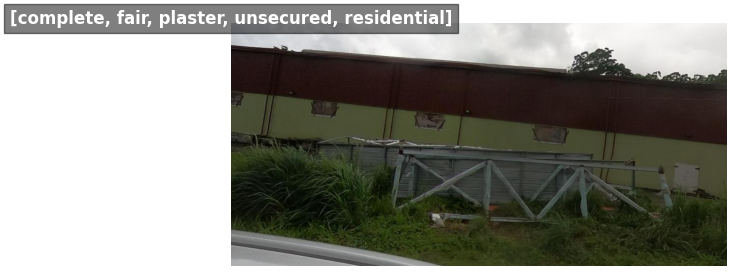

File  sVDfTtZgioxYQJrk6clSeI/left/317396310690052_left.jpg  with ground truth attributes  {'building_completeness': 'complete', 'building_condition': 'fair', 'building_material': 'mix-other-unclear', 'building_security': 'unsecured', 'building_use': 'residential', 'occluded': False, 'rotation': 0.0}


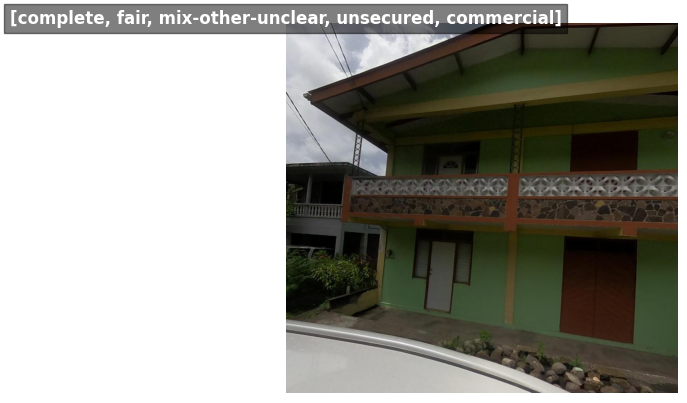

File  rb3QV25WsP0NdylOHZSzxE/left/330498719422552_left.jpg  with ground truth attributes  {'building_completeness': 'complete', 'building_condition': 'poor', 'building_material': 'plaster', 'building_security': 'unsecured', 'building_use': 'mixed', 'occluded': False, 'rotation': 0.0}


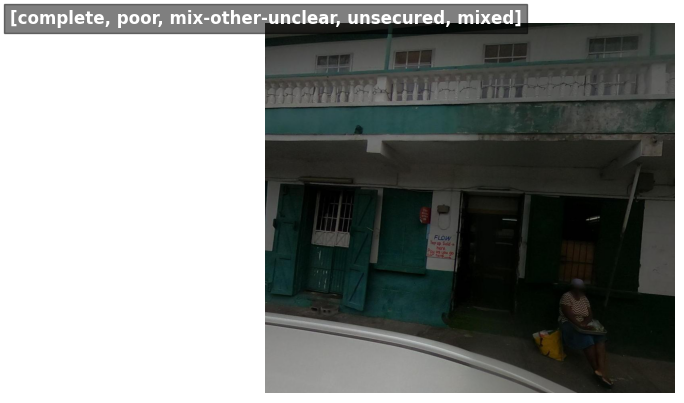

File  rb3QV25WsP0NdylOHZSzxE/left/830052638707374_left.jpg  with ground truth attributes  {'building_completeness': 'incomplete', 'building_condition': 'poor', 'building_material': 'corrugated_metal', 'building_security': 'unsecured', 'building_use': 'residential', 'occluded': False, 'rotation': 0.0}


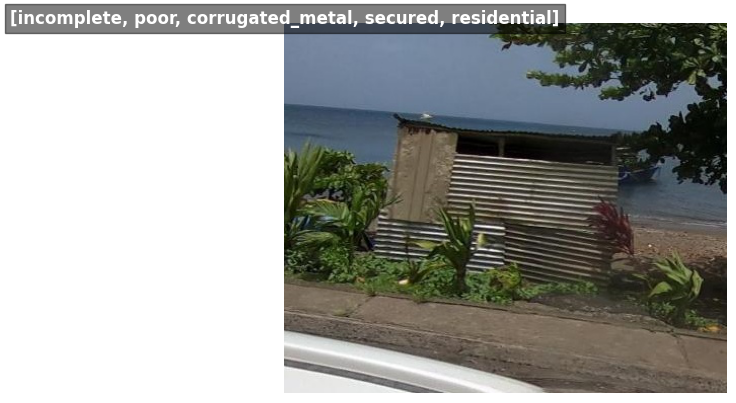

File  rb3QV25WsP0NdylOHZSzxE/left/295172426598155_left_2.jpg  with ground truth attributes  {'building_completeness': 'complete', 'building_condition': 'poor', 'building_material': 'plaster', 'building_security': 'secured', 'building_use': 'mixed', 'occluded': False, 'rotation': 0.0}


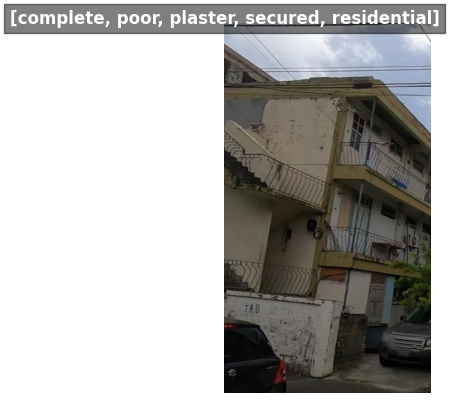

File  sVDfTtZgioxYQJrk6clSeI/left/1464783370936895_left_2.jpg  with ground truth attributes  {'building_completeness': 'complete', 'building_condition': 'poor', 'building_material': 'wood_polished', 'building_security': 'unsecured', 'building_use': 'residential', 'occluded': False, 'rotation': 0.0}


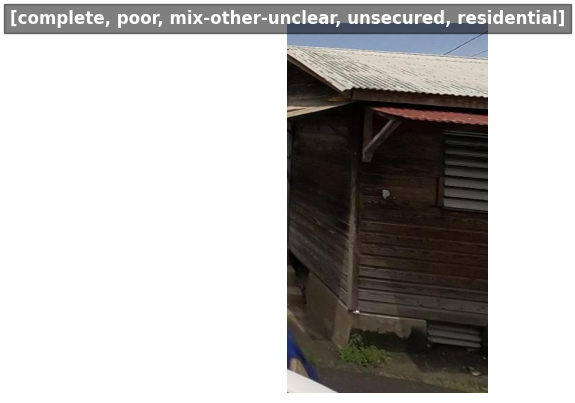

File  sVDfTtZgioxYQJrk6clSeI/left/1354190961832569_left_2.jpg  with ground truth attributes  {'building_completeness': 'complete', 'building_condition': 'poor', 'building_material': 'mix-other-unclear', 'building_security': 'secured', 'building_use': 'residential', 'occluded': False, 'rotation': 0.0}


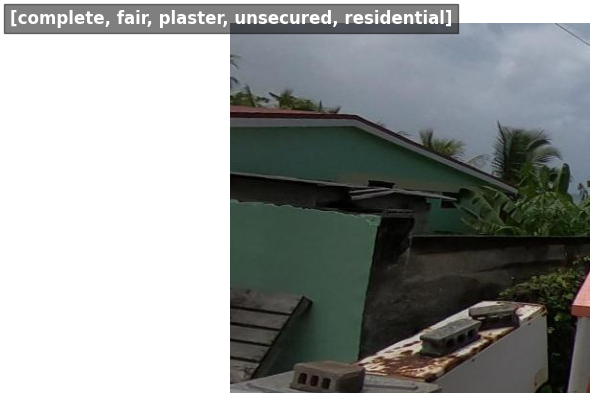

File  r7tGTdge9ZQXVPAcNbiEnu/left/2648202768667523_left_2.jpg  with ground truth attributes  {'building_completeness': 'complete', 'building_condition': 'fair', 'building_material': 'plaster', 'building_security': 'secured', 'building_use': 'residential', 'occluded': False, 'rotation': 0.0}


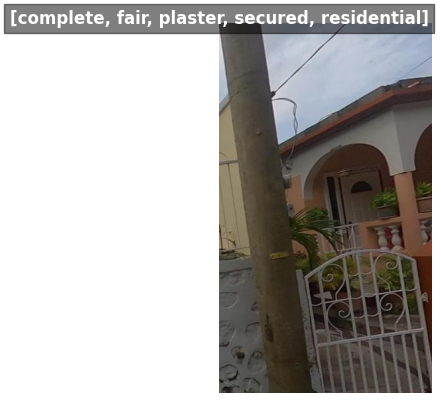

File  rb3QV25WsP0NdylOHZSzxE/left/1498491417358362_left_2.jpg  with ground truth attributes  {'building_completeness': 'complete', 'building_condition': 'fair', 'building_material': 'mix-other-unclear', 'building_security': 'secured', 'building_use': 'residential', 'occluded': False, 'rotation': 0.0}


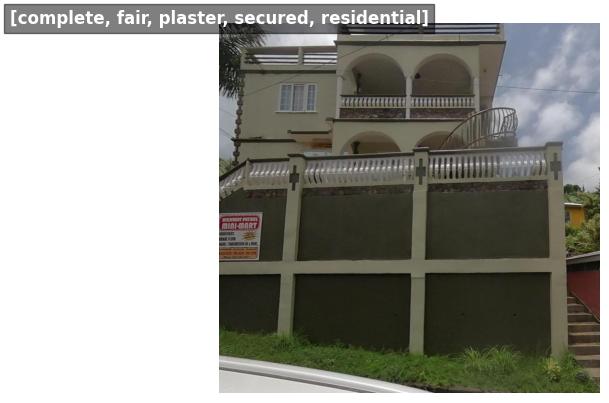

File  sVDfTtZgioxYQJrk6clSeI/left/345064584539357_left.jpg  with ground truth attributes  {'building_completeness': 'complete', 'building_condition': 'fair', 'building_material': 'mix-other-unclear', 'building_security': 'unsecured', 'building_use': 'residential', 'occluded': False, 'rotation': 0.0}


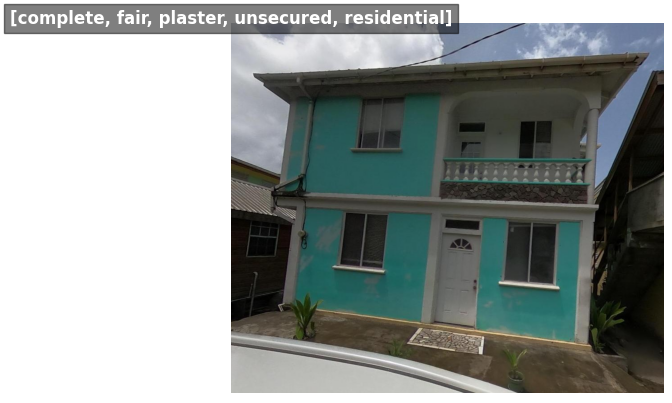

In [90]:
df_preds_ = df_preds.sample(frac=1).reset_index(drop=True)

# Display images and bounding boxes for a random selection of tiles
for id, p in df_preds_.head(10).iterrows():
    if os.path.exists(f"output/test_inference_images/{p.image_name_clip}"):
        img = rasterio.open(f"./output/test_inference_images/{p.image_name_clip}")
        imgr = img.read()
        print("File ", p.image_name_clip, " with ground truth attributes ", p.ground_truth)
        fig, ax = plt.subplots()
        ax.imshow(imgr.transpose(1, 2, 0))
            
        plt.text(0.5, -0.1, f"[{p.complete}, {p.condition}, {p.material}, {p.security}, {p.use}]", ha='center', fontsize=12, color='white', fontweight='bold', bbox=dict(facecolor='black', alpha=0.5))
        plt.axis('off')
        plt.show()

    else:
        pass

#### This is a peek into what the predictions csv output looks like

In [75]:
df_preds.head(10)

image_name  \
0  r7tGTdge9ZQXVPAcNbiEnu/left/1746355092495649_l...   
1  r7tGTdge9ZQXVPAcNbiEnu/left/1796054077478724_l...   
2  r7tGTdge9ZQXVPAcNbiEnu/left/1797722660681962_l...   
3  r7tGTdge9ZQXVPAcNbiEnu/left/1939599736440639_l...   
4  r7tGTdge9ZQXVPAcNbiEnu/left/1939599736440639_l...   
5  r7tGTdge9ZQXVPAcNbiEnu/left/1939599736440639_l...   
6  r7tGTdge9ZQXVPAcNbiEnu/left/1939599736440639_l...   
7  r7tGTdge9ZQXVPAcNbiEnu/left/1966801483681588_l...   
8  r7tGTdge9ZQXVPAcNbiEnu/left/1988227758197966_l...   
9  r7tGTdge9ZQXVPAcNbiEnu/left/2012497842450451_l...   

                                               boxes  \
0  [713.345458984375, 253.937255859375, 1022.2023...   
1  [482.8565368652344, 392.7989501953125, 1019.79...   
2  [107.59165954589844, 127.55589294433594, 682.8...   
3  [0.5353906154632568, 246.79296875, 391.3089904...   
4  [378.7174072265625, 15.589765548706055, 827.27...   
5  [0.5353906154632568, 246.79296875, 391.3089904...   
6  [378.7174072265625, 15.589765548706055, 827.27...   
7  [271.408203125, 437.2467041015625, 1021.005737...   
8  [76.96910095214844, 54.42814254760742, 836.309...   
9  [631.1368408203125, 273.9692077636719, 1022.17...   

                        box_scores    complete condition           material  \
0  tensor(0.9842, device='cuda:0')    complete      fair            plaster   
1  tensor(0.9918, device='cuda:0')    complete      good            plaster   
2  tensor(0.9996, device='cuda:0')    complete      poor  mix-other-unclear   
3  tensor(0.9970, device='cuda:0')    complete      fair            plaster   
4  tensor(0.9717, device='cuda:0')  incomplete      poor  mix-other-unclear   
5  tensor(0.9970, device='cuda:0')    complete      poor            plaster   
6  tensor(0.9717, device='cuda:0')  incomplete      poor  mix-other-unclear   
7  tensor(0.9931, device='cuda:0')  incomplete      poor   corrugated_metal   
8  tensor(0.9789, device='cuda:0')    complete      good            plaster   
9  tensor(0.9783, device='cuda:0')    complete      poor  mix-other-unclear   

    security          use                                    image_name_clip  
0  unsecured  residential  r7tGTdge9ZQXVPAcNbiEnu/left/1746355092495649_l...  
1  unsecured  residential  r7tGTdge9ZQXVPAcNbiEnu/left/1796054077478724_l...  
2  unsecured  residential  r7tGTdge9ZQXVPAcNbiEnu/left/1797722660681962_l...  
3  unsecured  residential  r7tGTdge9ZQXVPAcNbiEnu/left/1939599736440639_l...  
4  unsecured        mixed  r7tGTdge9ZQXVPAcNbiEnu/left/1939599736440639_l...  
5  unsecured   commercial  r7tGTdge9ZQXVPAcNbiEnu/left/1939599736440639_l...  
6  unsecured        mixed  r7tGTdge9ZQXVPAcNbiEnu/left/1939599736440639_l...  
7  unsecured  residential  r7tGTdge9ZQXVPAcNbiEnu/left/1966801483681588_l...  
8    secured  residential  r7tGTdge9ZQXVPAcNbiEnu/left/1988227758197966_l...  
9    secured  residential  r7tGTdge9ZQXVPAcNbiEnu/left/2012497842450451_l...